Transparent Bayesian Age Depth Modelling
==================
 -- a new transparent method for analyzing age depth data --
------------------------------------

The input file must be of type .csv and follow the format below. The first line describes the columns, where we have an ID in the first column, which is simply a line counter. The second column contains the ages, the third column represents the errors of the ages in the sense of a standard deviation. The last column contains the depth. 

"labID","age","error","depth"<br>
1,2.385,0.231,3<br>
2,9.960,0.346,43<br>
3,13.258,0.158,67<br>
4,15.391,0.140,93<br>
5,16.857,0.158,149<br>
6,17.172,0.254,203<br>
7,18.314,0.236,249<br>
8,19.498,0.369,313<br>
9,22.724,0.292,491<br>
10,25.007,0.379,515<br>
11,26.612,0.524,662<br>


The units of our data are ka for the ages and errors, and cm for the depths.
Now we define the input file in R, where we leave out the .csv ending:

In [103]:
inFile <- "/home/jovyan/work/TBADM/SO213-76-2_p"

and load the file:

In [104]:
ageData <- read.table(paste(inFile,".csv",sep=""), header = TRUE,sep=",")

To inspect the data we now create a simple plot, where we also plot the errors, which have to interpreted here in the sense of a standard deviation.

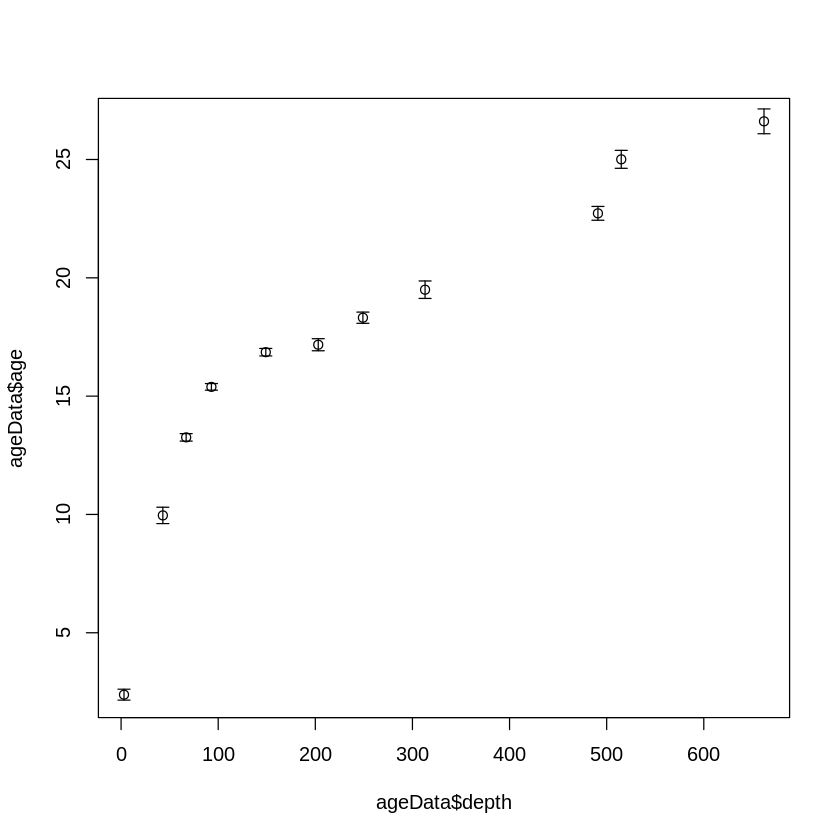

In [105]:
plot(ageData$depth,ageData$age)
arrows(ageData$depth, ageData$age-ageData$error, ageData$depth, 
       ageData$age+ageData$error, length=0.05, angle=90, code=3,col="black",lwd=1)

Now we have to define an important setting, i.e. the definition of the number and position of the segments. Therefor we have to define a vector containing the positions of the segments. For instance, if we want to divide the age depth data into 3 segments, the first from position 1 to 5, the second from 6 to 9 and the last from 10 to 12, we have to define the vector: c(5,9), indicating the connection points of the segments.
For this dataset we use 2 segments, the first from 1 to 4 and the second from 5 to 11, thus we define:

In [106]:
segPos <- c(4)

We further define some "helper" variables e.g. the length of the data:

In [107]:
lengthData <- length(ageData$depth)

The basis of applying the method is the estimation of the accumulation rates, which are simply given by the discrete differential quotients, scaled by the depth increments to maintain the correct units. Thus we first calculate the depth increments.

In [108]:
diffDepths <- diff(ageData$depth)

And then the accumulation rates:

In [109]:
accRates <- diff(ageData$age)/diffDepths

The problem is now that we have no estimate for the first accumulation rate, thus we take the origin (0,0), i.e. an age of 0 ka and depth of 0 cm and add it to the accumulation rates:

In [110]:
accRates <- c(ageData$age[1]/ageData$depth[1],accRates)

Accordingly to estimating the rates, we have to estimate the errors of the rates in a Gaussian sense, i.e. the error of a difference (rate) is given by the sum of the errors of the original data. Similar to above we must account for the error of the first data point.

In [111]:
sigmaRates <- sqrt((ageData$error[2:lengthData]^2+ageData$error[1:(lengthData-1)]^2))/diffDepths
sigmaRates <- c(ageData$error[1]/ageData$depth[1],sigmaRates)

As you have seen, we used R's standard element wise handling of arrays, by calculating the sums of the errors of the current value $[2:lengthData]$ and the one before $[1:(lengthData-1)]$. 
Now we create a simple plot to have a look on the estimated rates and errors.

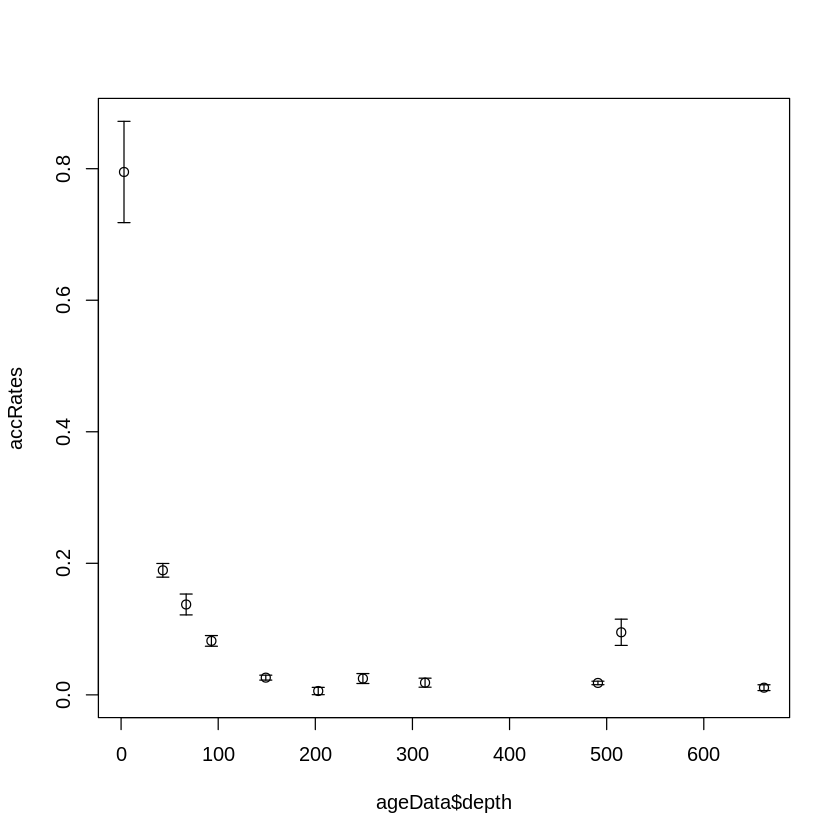

In [112]:
ymin <- min(accRates-sigmaRates)
ymax <- max(accRates+sigmaRates)
plot(ageData$depth,accRates,ylim=c(ymin,ymax))
arrows(ageData$depth, accRates-sigmaRates, ageData$depth, 
       accRates+sigmaRates, length=0.05, angle=90, code=3,col="black",lwd=1)

Now we are coming to the point where we want to fit the rates using straight lines for the segments. Taking simply the mean within the segments would be fine. However to be a little more robust against outliers we use the median. So, adjust the here used method to your personal needs, if you are using your own data.
First we define arrays for the fitted curve and the error.

In [113]:
fittedRates <- rep(0,lengthData)
fittedError <- rep(0,lengthData)

Now we define helpers to go through the segments, i.e. we add $0$ and $lengthData$ to $segPos$:

In [114]:
segPos <- c(0,segPos,lengthData)
segPosLength <- length(segPos)

We now use a loop to go through the segments, and estimate the median and error within the segments.

In [115]:
for (i in seq(2,segPosLength)) {
        fittedRates[(segPos[i-1]+1):segPos[i]] <- mean(accRates[(segPos[i-1]+1):segPos[i]])
        fittedError[(segPos[i-1]+1):segPos[i]] <- sd(accRates[(segPos[i-1]+1):segPos[i]])
    }

We have now fitted the accumulation rates and can visualise the data and the fit. To visualise the error of the fit we use polygons. For the fit we use red triangles connected with a red line.

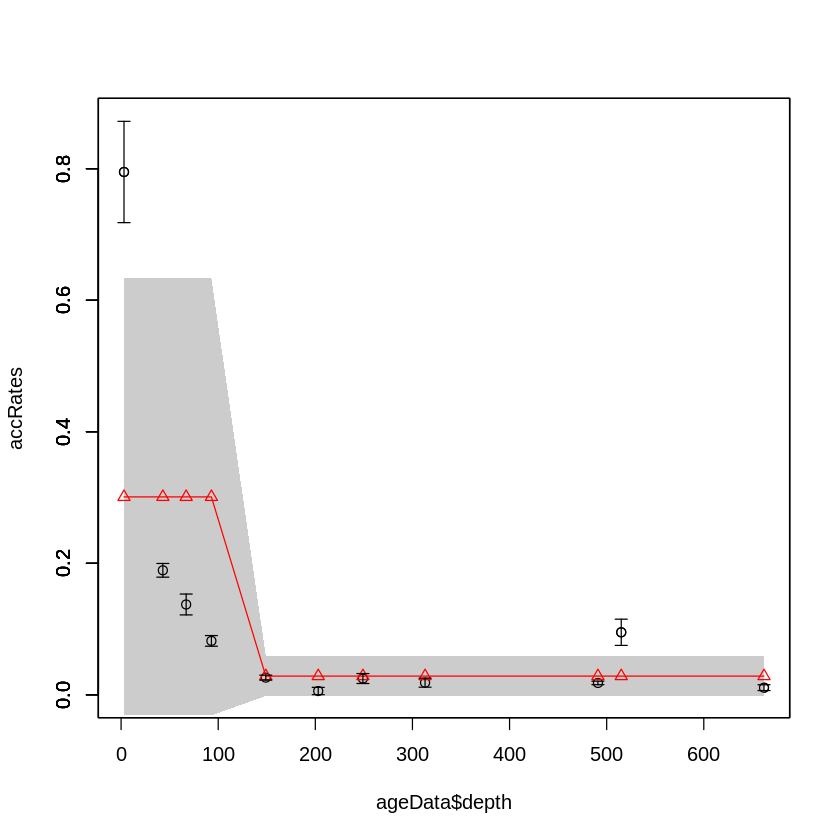

In [116]:
ymin <- min(accRates-sigmaRates)
ymax <- max(accRates+sigmaRates)
plot(ageData$depth,accRates,ylim=c(ymin,ymax))
par(new=TRUE)
polygon(c(ageData$depth, rev(ageData$depth)), c(fittedRates-fittedError,
        rev(fittedRates+fittedError)), col=rgb(0.8,0.8,0.8),border=NA)
par(new=TRUE)
plot(ageData$depth,accRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n")
par(new=TRUE)
plot(ageData$depth,fittedRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",pch=2,col="red")
par(new=TRUE)
plot(ageData$depth,fittedRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",type="l",col="red")


arrows(ageData$depth, accRates-sigmaRates, ageData$depth, 
       accRates+sigmaRates, length=0.05, angle=90, code=3,col="black",lwd=1)

As we can see from the figure above we have now nicely fitted the rates using straight lines. Since we used the robust median to estimate the lines, the rate a $depth=0$ has only weak influence on the fit.

The fit is good, however we can improve it. The human visual system has an enormous ability to fit patterns together. If we were able to move each fitted point a little bit to improve the fit, we would probably shift each triangle a little bit into the direction of the original data point. But what is "a little bit"? Bayesian statistics can help us pouring this into a clear and concise mathematical procedure. Although Bayesian statistics is a mathematical theory based on fundamental concepts of probability, it often provides a certain common sense or it can be used as a tool to clearly define a scientist understanding of data. 

Our data (ages and rates) have an error, the fit has also an error. Based on our scientific expertise we would not really be satisfied saying that the fit is the best estimate of the true rates, because many details are not reproduced by the fit. Additionally we would not like to treat our original data as the best estimate of the "truth", because they are probably too error proned. Thus the best estimate seems to be inbetween the original measurements and the fit. 

This can be formulated using probability theory and Bayes theorem. Bayes theorem is given by

$\mbox{prob}(Y|X)=\frac{\mbox{prob}(X|Y) \, \times \mbox{prob}(Y)}{\mbox{prob}(X)}$

The left part is called posterior probability, the first term on the right side is the likelihood, the right term the prior probability, whereas the term in the denominator is mostly named evidence.

For a better understanding, the terms can also be interpreted as:

$\mbox{prob}(hypothesis|data) \propto \mbox{prob}(data|hypothesis) \times \mbox{prob}(hypothesis)$

We have omitted the denominator, which represents essentially a normalisation factor and thus replaced the $=$ by a $\propto$. In the case of normalised likelihood and prior the $=$ can be used because the evidence would be unity.

In words this means that we want to estimate the probability of a hypothesis given specific data. This can be indeed calculated if we know the probability of the data given the hypothesis and the probability of the hypothesis itself.

Regarding our age data we can now ask what is the probabilty of observing a best estimate of the true rates given our observation:


$\mbox{prob}(fittedRates|accRates) \propto \mbox{prob}(accRates|fittedRates) \, \times \mbox{prob}(fittedRates)$

A crucial point is now to follow a Gaussian approach, which allows us to solve the above equation analytical. In the case of a non-gaussian approach the solution can most probably only be found numerically, e.g. using a Markov Chain Monte Carlo (MCMC) algorithm.

Before identifying the exact Gaussians we can simplify the equation above. The likelihood, i.e. the probability of the rates given the fit reduces to $\mbox{prob}(accRates) = \mbox{prob}(accRates|fittedRates)$, thus:

$\mbox{prob}(fittedRates|accRates) \propto \mbox{prob}(accRates) \, \times \mbox{prob}(fittedRates)$

To every point of the estimated rates and the fit we can associate a Gaussian distribution. The probability of the estimated rates can be defined as $\mbox{prob}(accRates) = N(\mu=accRates,\sigma=sigmaRates)$. The probability of the fitted rates can be defined as $\mbox{prob}(fittedRates) = N(\mu=fittedRates,\sigma=fittedError)$.
Since we are dealing with Gaussian normal distributions, which are normalised per definition and fully described by the mean and standard deviation we can replace the $\propto$ by a $=$. 

Thus we have to calculate:

$\mbox{prob}(fittedRates|accRates) = N(\mu=accRates,\sigma=sigmaRates) \times N(\mu=fittedRates,\sigma=fittedError)$

We see that we can find a solution by multiplying two Gaussian distributions. The multiplication of two Gaussians $f$ and $g$ with means $\mu_f$ and $\mu_g$ and variances $V_f$ and $V_g$ is given by the following formulas:

mean $=\frac{\mu_f V_g + \mu_g V_f}{V_f+V_g}$

variance = $\frac{V_f \times V_g}{V_f+V_g}$

which yield the mean and variance. However, it has to be noted that the product of two Gaussians is.

Interestigly it turns out that the new estimate of the fitted rates is exactly the weighted mean of the observations and the fitted rates, whereas the errors represent the weights. This result is due to fact that we used a Gaussian assumption. Further it can be seen that this approach is a so called objective Bayesian analysis, because it involves no subjective prior information, again due to the Gaussian approach.

Applying these formulas to our data, we get a new estimate for the fitted accumulation rates:

In [117]:
BayesFittedRates <- (fittedRates * sigmaRates^2 + accRates * fittedError^2)/(fittedError^2 + sigmaRates^2)

In [118]:
BayesSigmaRates <- sqrt((fittedError^2 * sigmaRates^2)/(fittedError^2 + sigmaRates^2))

Now we have observed new best estimates for our accumulation rates. This process of updating existing information using prior information is exactly one part of the Bayesian spirit. Following we can plot the results.

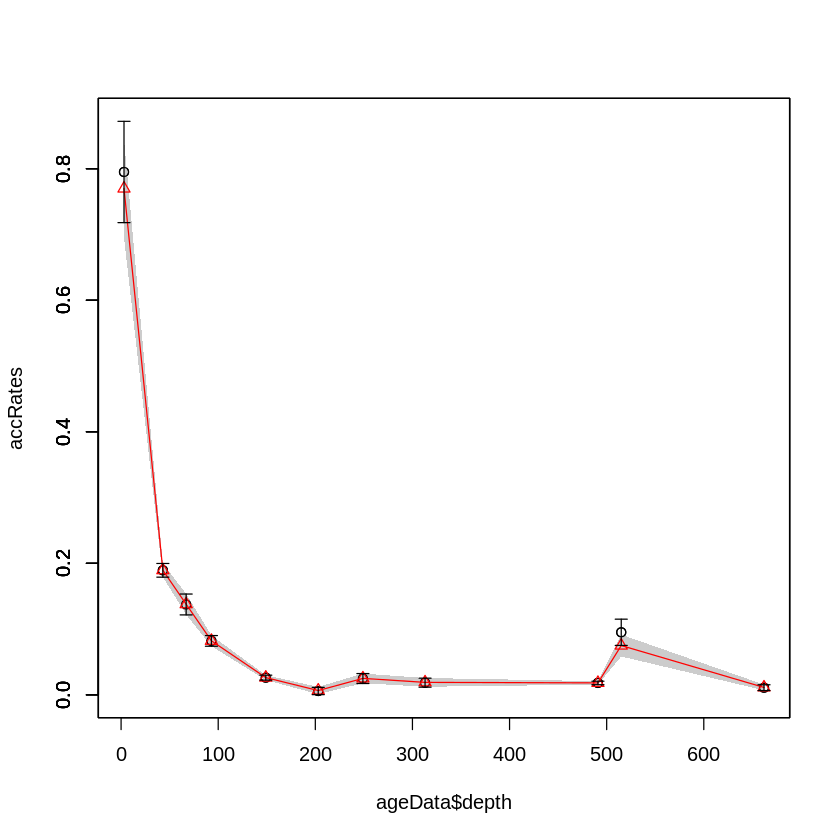

In [119]:
ymin <- min(accRates-sigmaRates)
ymax <- max(accRates+sigmaRates)
plot(ageData$depth,accRates,ylim=c(ymin,ymax))
par(new=TRUE)
polygon(c(ageData$depth, rev(ageData$depth)), c(BayesFittedRates-BayesSigmaRates,
        rev(BayesFittedRates+BayesSigmaRates)), col=rgb(0.8,0.8,0.8),border=NA)
par(new=TRUE)
plot(ageData$depth,accRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n")
par(new=TRUE)
plot(ageData$depth,BayesFittedRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",pch=2,col="red")
par(new=TRUE)
plot(ageData$depth,BayesFittedRates,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",type="l",col="red")


arrows(ageData$depth, accRates-sigmaRates, ageData$depth, 
       accRates+sigmaRates, length=0.05, angle=90, code=3,col="black",lwd=1)

As can be seen from the above figure, the fit (red triangles, red line) comes very close to the observations. The reason is clear. In the first segment (point 1 to 4), the error of the prior fit is very large and the errors of the data points are small, thus the data points are weighted much more than the prior fit and the posterior is influenced only very weak by the prior. The error of the prior in the second segment is much smaller, still the errors of the data points are even smaller thus again, the posterior fit is strongly attracted by the observations. This behavior makes clearly sense. If we have such small errors, we should trust our measurements.

The final step is now of course to reconstruct the ages from the rates. Therefore we simply create the cumulative sum of the new Baysian fittet rates to obtain the observations.

In [120]:
ageFit <- cumsum(BayesFittedRates * c(ageData$depth[1],diffDepths))

The errors of the $ageFit$ data can again easily estimated using a standard Gaussian approach:

In [121]:
ageFitError <- rep(0,lengthData)
ageFitError[1] <- BayesSigmaRates[1]*ageData$depth[1]
for (i in seq(1,(lengthData-1))) {                                                                                                                                                              
    ageFitError[i+1] <- sqrt(ageFitError[i]^2+(BayesSigmaRates[i+1]*diffDepths[i])^2)
}


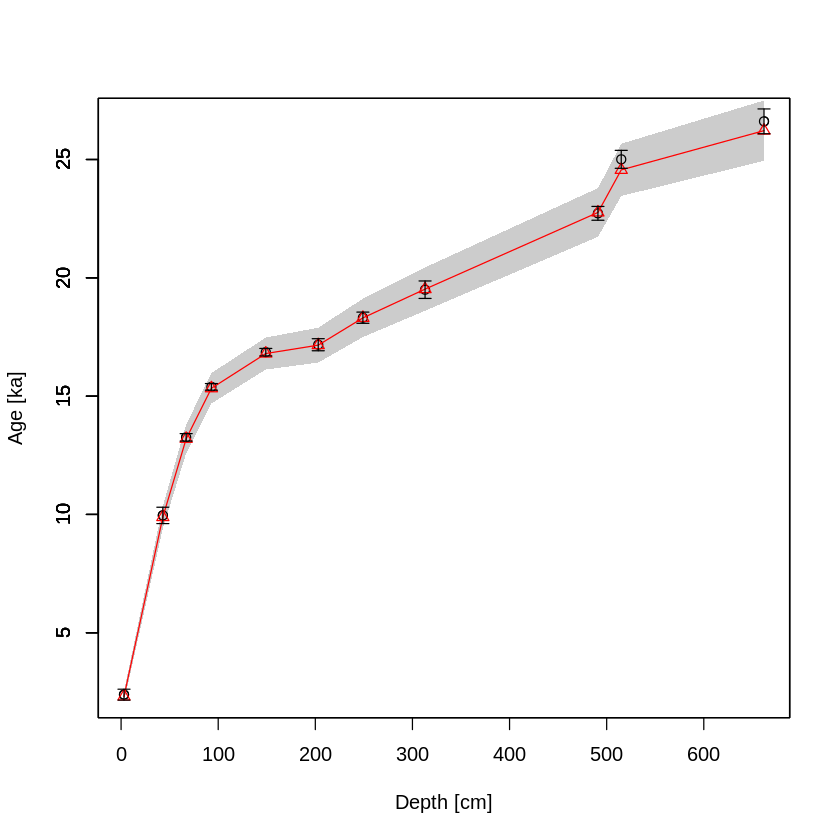

In [126]:
ymin <- min(ageData$age)
ymax <- max(ageData$age)
plot(ageData$depth,ageData$age,ylim=c(ymin,ymax),xlab="Depth [cm]",ylab="Age [ka]")
par(new=TRUE)
polygon(c(ageData$depth, rev(ageData$depth)), c(ageFit-ageFitError,
        rev(ageFit+ageFitError)), col=rgb(0.8,0.8,0.8),border=NA)
par(new=TRUE)
plot(ageData$depth,ageData$age,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n")
par(new=TRUE)
plot(ageData$depth,ageFit,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",pch=2,col="red")
par(new=TRUE)
plot(ageData$depth,ageFit,ylim=c(ymin,ymax),xlab="",ylab="",xaxt="n",xaxt="n",type="l",col="red")

arrows(ageData$depth, ageData$age-ageData$error, ageData$depth, 
       ageData$age+ageData$error, length=0.05, angle=90, code=3,col="black",lwd=1)

For science application it is now of course interesting to get interpolated values at positions, where we have no data. As a first simple try we interpolate linearly to a 1 cm resolution:

In [132]:
depthInterp <- seq(ageData$depth[1],ageData$depth[lengthData])
lengthInterp <- length(depthInterp)
ageFitInterp <- approx(x=ageData$depth,y=ageFit,xout=depthInterp,method="linear")
ageFitErrorInterp <- approx(x=ageData$depth,y=ageFitError,xout=depthInterp,method="linear")

#write to disk
out <- replicate(3,rep(0,lengthInterp))
out[,1] <- ageFitInterp$x
out[,2] <- ageFitInterp$y
out[,3] <- ageFitErrorInterp$y

write(t(out),file=paste(inFile,"_interp.txt",sep=""),ncolumns=3)


Concluding we see that we have a transparent, clearly defined, robust and fast method to fit and interpolate age depth data. The method is based on the physical assumption of accumulation rates who control the deposition of sediments. Using a Gaussian approximation we are able to apply a Bayesian concept analytically, which gives us a basis to estimate a best fit. Due to the Gaussian approach it turns out that the best fit or posterior fit is given by the weighted mean of the original observations (rates) and the prior fit (straight lines). The advantages of the method are that it is totally transparent and easy to understand. Uncertainties are clearly described and the error calculation is straight forward. Because the method is completely analytical numerical errors do not exists, in contrast to methods, which use e.g. MCMC algorithms. Further, without the plotting parts the algorithm has a size of approximately 35 lines of R code, which makes it absolutely minimal, easy to understand, adapt and maintain.